# Watermark Remover - training

In [1]:
import tensorflow as tf
from training.dataset_handler import *
import os
import random
import matplotlib.pyplot as plt
import cv2
from model import *
import numpy as np

## 1. Prepare dataset

In [2]:
input_dir = "training/dataset/labeled"
output_dir = "training/dataset/images"

batch_size = 8
img_height = 512
img_width = 512
img_size = (img_width, img_height)

# Get data
input_img_paths = [ os.path.join(input_dir, fname) for fname in os.listdir(input_dir) if ".jpg" in fname]
output_img_paths = [ os.path.join(output_dir, fname) for fname in os.listdir(output_dir) if ".jpg" in fname]

input_img_paths.sort()
output_img_paths.sort()

# Prepare dataset sequence
val_samples = 150
random.Random(42).shuffle(input_img_paths)
random.Random(42).shuffle(output_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_output_img_paths = output_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_output_img_paths = output_img_paths[-val_samples:]

train_gen = WatermarkedImages(batch_size, img_size, train_input_img_paths, train_output_img_paths)
val_gen = WatermarkedImages(batch_size, img_size, val_input_img_paths, val_output_img_paths)

In [3]:
batch_id = 0
x_train, y_train = train_gen.__getitem__(batch_id)

In [4]:
np.shape(y_train[5])

(512, 512, 3)

## 2. Examples

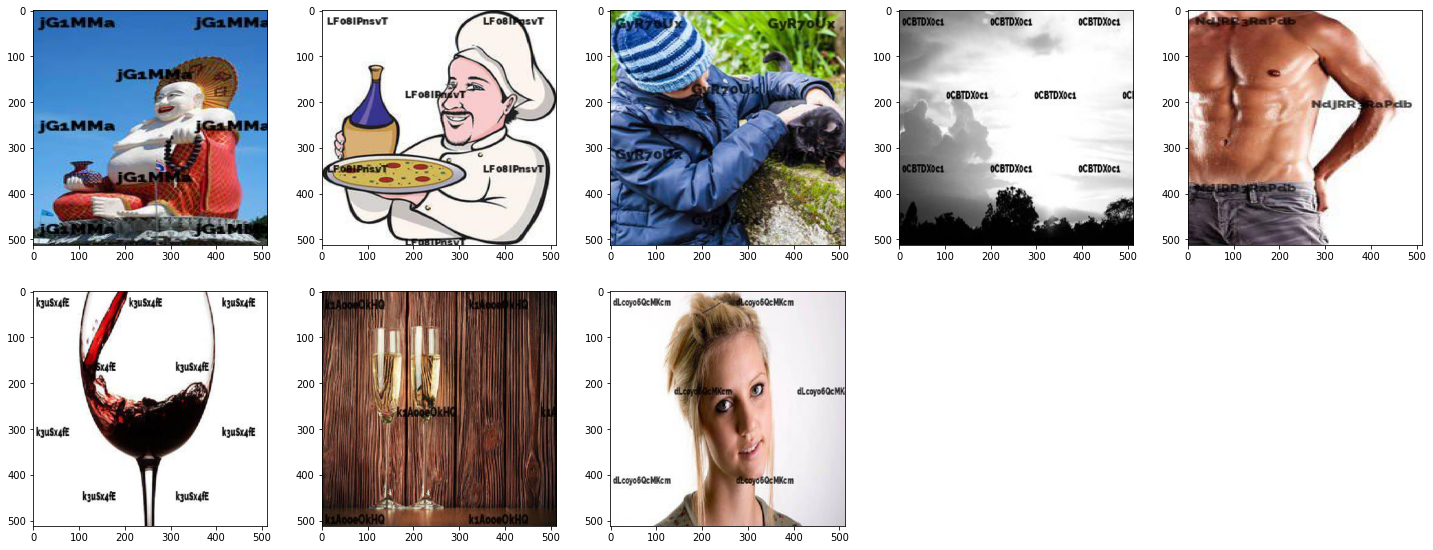

In [5]:
plt.figure(figsize=(25,25))
for i in range(batch_size):
    plt.subplot(5,5,i+1)
    plt.imshow(x_train[i])
plt.show()

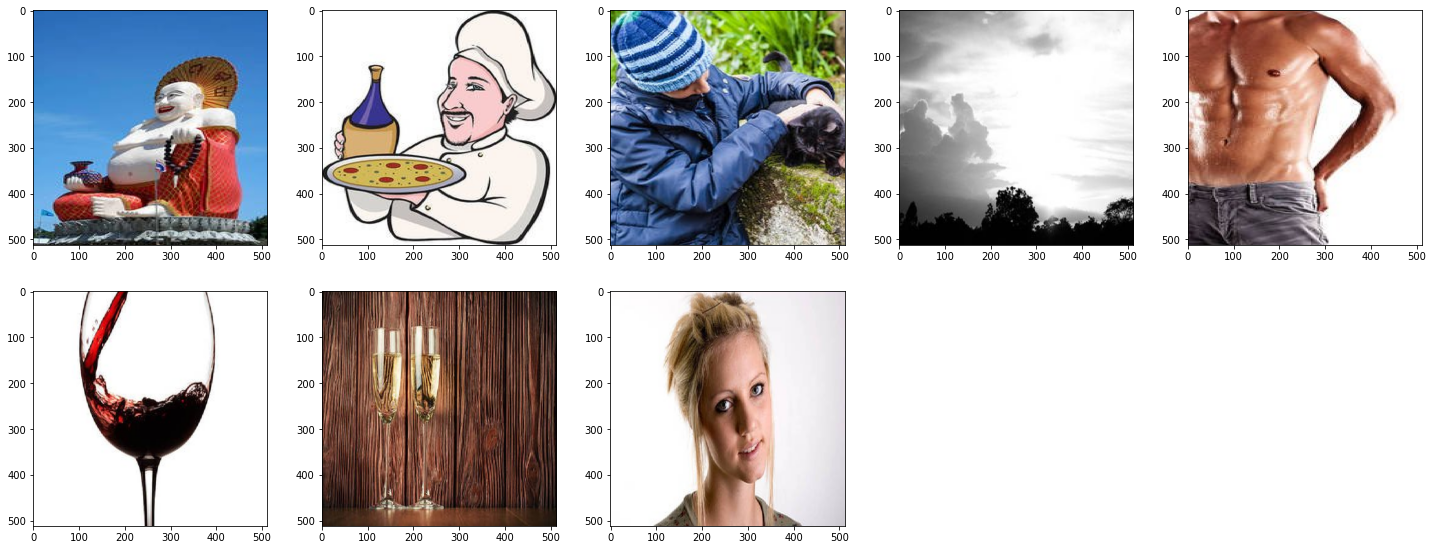

In [6]:
plt.figure(figsize=(25,25))
for i in range(batch_size):
    plt.subplot(5,5,i+1)
    plt.imshow(y_train[i])
plt.show()

## 3. Build model and train

In [7]:
# model = simple_cnn(img_size)
model = encoder_decoder(img_size)

model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='mse')

2022-07-26 21:02:20.203395: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-26 21:02:20.277910: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-26 21:02:20.278851: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-26 21:02:20.281752: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 512, 512, 64)      9472      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 256, 256, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 64)      200768    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 128, 128, 64)     0         
 2D)                                                             
                                                                 
 conv2d_transpose (Conv2DTra  (None, 256, 256, 64)     200768    
 nspose)                                                         
                                                        

In [8]:
callbacks = [
        keras.callbacks.ModelCheckpoint("watermark_remover.h5", save_best_only=True)
    ]
    
epochs = 15
history = model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/15


2022-07-26 21:02:25.182947: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2022-07-26 21:02:26.892221: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-07-26 21:02:26.892856: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-07-26 21:02:26.892952: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-07-26 21:02:26.893544: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-07-26 21:02:26.893678: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


237/237 [==============================] - 298s 1s/step - loss: 0.0293 - val_loss: 0.0092
Epoch 2/15
237/237 [==============================] - 284s 1s/step - loss: 0.0076 - val_loss: 0.0047
Epoch 3/15
237/237 [==============================] - 283s 1s/step - loss: 0.0058 - val_loss: 0.0063
Epoch 4/15
237/237 [==============================] - 283s 1s/step - loss: 0.0048 - val_loss: 0.0033
Epoch 5/15
237/237 [==============================] - 284s 1s/step - loss: 0.0041 - val_loss: 0.0031
Epoch 6/15
237/237 [==============================] - 283s 1s/step - loss: 0.0036 - val_loss: 0.0034
Epoch 7/15
237/237 [==============================] - 284s 1s/step - loss: 0.0032 - val_loss: 0.0025
Epoch 8/15
237/237 [==============================] - 283s 1s/step - loss: 0.0030 - val_loss: 0.0029
Epoch 9/15
237/237 [==============================] - 283s 1s/step - loss: 0.0033 - val_loss: 0.0026
Epoch 10/15
237/237 [==============================] - 284s 1s/step - loss: 0.0029 - val_loss: 0.0023


## 4. Test

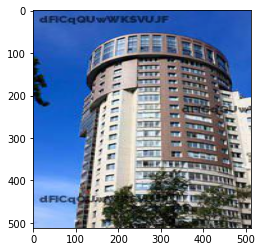

In [9]:
test_x, test_y = val_gen.__getitem__(2)
plt.imshow(test_x[0])

In [10]:
result = model.predict(test_x)

1/1 [==============================] - 0s 178ms/step


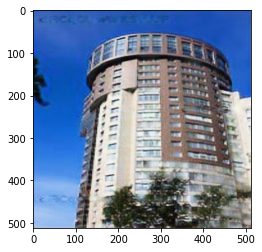

In [11]:
plt.imshow(result[0])